# Understanding and Predicting Employee Turnover

## HR Analytics

### Author: Harry Patterson

                              ====================================================

## Table of Contents
### The Problem
- [Why is Employee Turnover a Problem?](#Problem)

### Data Quality Check
- [Simple Inspection of Data](#datacleaning)

### Descriptive Statistics
- [Summary Statistics, Turnover Rate, Size of Data](#descriptive_statistics)
- [Correlation Matrix](#correlation_matrix)

### Exploratory Data Analysis
- [Employee Satisfaction, Evaluation, and Project Count Distribution](#eda1)
- [Employee Satisfaction VS Evaluation](#eda2)
- [K Means Clustering of Employee](#eda3)
- [Employee Satisfaction Distribution](#eda4)
- [Employee Project Count Distribution](#eda5)
- [Employee Department Distribution](#eda6)
- [Employee Average Monthly Hours Distribution](#eda7)

### Simple Pre-Processing
- [Pre-Processing: Categorical and Numerical Variable](#pre_processing)

### Class Imbalance
- [How to Treat Class Imbalance Problems](#class_imbalance)

### Split Train/Test Set
- [Splitting the Data into Train/Test Sets](#train-test)

### Resample Techniques to Treat Imbalance Data
- [Evaluate Original, Upsampled, and Downsampled Data Metrics](#resample)
- [Choose Which Sampling Technique to Use For Model - Upsampling](#upsampling)

### Train/Test Model Perfomance with 5-Fold CV
- [Logistic Regression Classifier](#lr)
- [Random Forest Classifier](#rf)
- [Gradient Boosting](#Gb)

### Evaluation Metric (F1 Score & ROC/AUC)
- [ROC and AUC](#roc)
- [Predictions on Testind Data](#Testing)
- [Feature Importance](#feature_importance)

### Conclusion
- [Report](#report)
- [Ending Remarks](#Conclusion)

***
### Objective: 
- To understand what factors contributed most to employee turnover.

- To perform clustering to find any meaningful patterns of employee traits.

- To create a model that predicts the likelihood if a certain employee will leave the company or not. 

- To create or improve different retention strategies on targeted employees. 

- The implementation of this model will allow management to create better decision-making actions.

<a id='Problem'></a>
### The Problem:

One of the most common problems at work is **turnover.** 

Replacing a worker earning about **50,000 dollars** cost the company about **10,000 dollars** or 20% of that worker’s yearly income according to the Center of American Progress.

Replacing a high-level employee can cost multiple of that...

**Cost include:**
- Cost of off-boarding 
- Cost of hiring (advertising, interviewing, hiring)
- Cost of onboarding a new person (training, management time)
- Lost productivity (a new person may take 1-2 years to reach the productivity of an existing person)

**Annual Cost of Turnover** = (Hiring + Onboarding + Development + Unfilled Time) * (# Employees x Annual Turnover Percentage)

**Annual Cost of Turnover** = (1,000 + 500) x (15,000 * 24%)

**Annual Cost of Turnover)** = 1500 x 3600

**Annual Cost of Turnover)** = 5400000

# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,precision_score,recall_score,confusion_matrix,precision_recall_curve
from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Read the Data

In [2]:
df = pd.read_csv('Data/HR-data.csv')
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


<a id='datacleaning'></a>
# Data Quality Check
***

In [4]:
# check missing values 
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [5]:
# Rename labels jsut for better readability 

df = df.rename(columns={'satisfaction_level':'satisfaction',
                       'last_evaluation':'evaluation',
                       'number_project':'projectCount',
                       'average_montly_hours':'averageMonthlyHours',
                       'time_spend_company':'yearsAtCompany',
                       'Work_accident':'WorkAccident',
                       'promotion_last_5years':'promotion',
                       'sales':'department',
                       'left':'turnover'})

df.head()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,turnover,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Make sure quality and datatypes matches the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satisfaction         14999 non-null  float64
 1   evaluation           14999 non-null  float64
 2   projectCount         14999 non-null  int64  
 3   averageMonthlyHours  14999 non-null  int64  
 4   yearsAtCompany       14999 non-null  int64  
 5   WorkAccident         14999 non-null  int64  
 6   turnover             14999 non-null  int64  
 7   promotion            14999 non-null  int64  
 8   department           14999 non-null  object 
 9   salary               14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
# Check type of the features
df.dtypes

satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
WorkAccident             int64
turnover                 int64
promotion                int64
department              object
salary                  object
dtype: object

<a id='descriptive_statistics'></a>
# Exploratory Data Analysis
***

In [8]:
# check rows and columns 
df.shape

(14999, 10)

In [9]:
# See turnover rate of the company's dataset.
turnover_rate = df.turnover.value_counts() / 14999
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

- Can see a class imbalance data set. Will balance to avoid any bias. 

In [10]:
# Look at how the data is distributed and statiscal overview
df.describe()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,turnover,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [11]:
# check to see is there any real significance for the people that left the company and didn't 
# show mean summary

turnover_summary = df.groupby('turnover')
turnover_summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


- can see that the people that did leave have about a 44% satisfaction compared to people who didn't at 67%
- People who left typcially worked more monthly hours 

In [12]:
turnover_summary.std()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,promotion
turnover,,,,,,,
0,0.217104,0.162005,0.979884,45.682731,1.562348,0.379991,0.159889
1,0.263933,0.197673,1.818165,61.202825,0.977698,0.212364,0.072759


<a id='correlation_matrix'></a>
### Correlation Matrix

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,turnover,promotion
satisfaction,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
projectCount,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
averageMonthlyHours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
yearsAtCompany,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
WorkAccident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
turnover,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


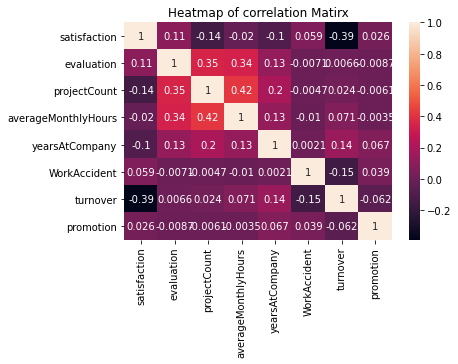

In [13]:
# Create a correlation matrix

corr = df.corr()
sns.heatmap(corr,
            annot=True,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
plt.title('Heatmap of correlation Matirx')
corr

- Most correlatated with turnover - Lower the satisfaction the employee have will result in a higher turnover
- Highest positive correlated features with turnover are yearsAtCompany and averageMonthlyHours. 

<a id='eda1'></a>
# EDA 1. 
## Distribution of Satisfaction, Evaluation, and Project Count

Text(0, 0.5, 'Employee Count')

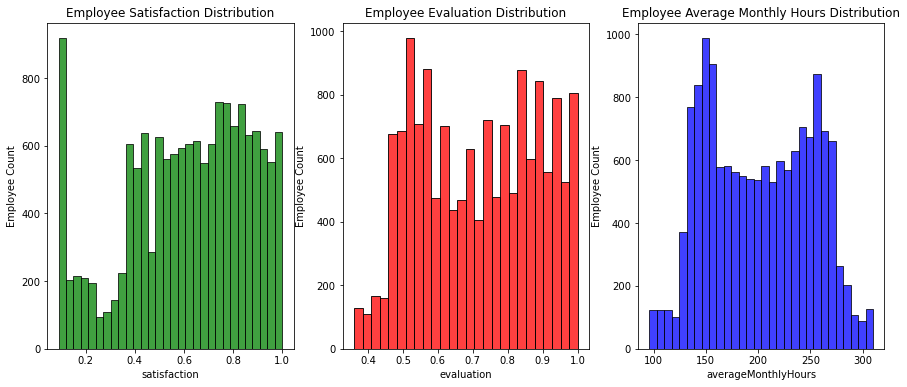

In [14]:
# Plot the distribution of Employee Satisfaction, Evaluation, and Project Count

# Set up the matplotlib figure 
f, axes = plt.subplots(ncols=3,figsize=(15,6))

# Graph employee satisfaction
sns.histplot(df.satisfaction,kde=False,color='g',ax=axes[0]).set_title('Employee Satisfaction Distribution')
axes[0].set_ylabel('Employee Count')

# Graph employee evaluation
sns.histplot(df.evaluation,kde=False,color='r',ax=axes[1]).set_title('Employee Evaluation Distribution')
axes[1].set_ylabel('Employee Count')

# Graph employee Average Monthly Hours
sns.histplot(df.averageMonthlyHours,kde=False,color='b',ax=axes[2]).set_title('Employee Average Monthly Hours Distribution')
axes[2].set_ylabel('Employee Count')

- How does these features effect the turnover rate 
- We can see that there are a lot of unsatisfied employees 
- Evaluation show pretty normal 
- We can see a clear separation between employee hours working less than 200 hours per month. 

In [15]:
df['satisfaction'].value_counts()

0.10    358
0.11    335
0.74    257
0.77    252
0.84    247
       ... 
0.25     34
0.28     31
0.27     30
0.12     30
0.26     30
Name: satisfaction, Length: 92, dtype: int64

In [16]:
df['satisfaction'].unique()

array([0.38, 0.8 , 0.11, 0.72, 0.37, 0.41, 0.1 , 0.92, 0.89, 0.42, 0.45,
       0.84, 0.36, 0.78, 0.76, 0.09, 0.46, 0.4 , 0.82, 0.87, 0.57, 0.43,
       0.13, 0.44, 0.39, 0.85, 0.81, 0.9 , 0.74, 0.79, 0.17, 0.24, 0.91,
       0.71, 0.86, 0.14, 0.75, 0.7 , 0.31, 0.73, 0.83, 0.32, 0.54, 0.27,
       0.77, 0.88, 0.48, 0.19, 0.6 , 0.12, 0.61, 0.33, 0.56, 0.47, 0.28,
       0.55, 0.53, 0.59, 0.66, 0.25, 0.34, 0.58, 0.51, 0.35, 0.64, 0.5 ,
       0.23, 0.15, 0.49, 0.3 , 0.63, 0.21, 0.62, 0.29, 0.2 , 0.16, 0.65,
       0.68, 0.67, 0.22, 0.26, 0.99, 0.98, 1.  , 0.52, 0.93, 0.97, 0.69,
       0.94, 0.96, 0.18, 0.95])

<a id='eda2'></a>
# EDA 2.
## Satisfaction VS Evaluation

- There are **3** distinct clusters for employees who left the company
 
**Cluster 1 (Hard-working and Sad Employee):** Satisfaction was below 0.2 and evaluations were greater than 0.75. Which could be a good indication that employees who left the company were good workers but felt horrible at their job. 
 - **Question:** What could be the reason for feeling so horrible when you are highly evaluated? Could it be working too hard? Could this cluster mean employees who are "overworked"?

**Cluster 2 (Bad and Sad Employee):** Satisfaction between about 0.35~0.45 and evaluations below ~0.58. This could be seen as employees who were badly evaluated and felt bad at work.
 - **Question:** Could this cluster mean employees who "under-performed"?

**Cluster 3 (Hard-working and Happy Employee):** Satisfaction between 0.7~1.0 and evaluations were greater than 0.8. Which could mean that employees in this cluster were "ideal". They loved their work and were evaluated highly for their performance. 
 - **Question:** Could this cluser mean that employees left because they found another job opportunity?

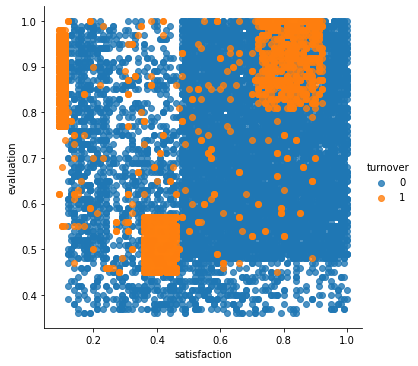

In [17]:
sns.lmplot(x='satisfaction',y='evaluation',data=df,
           fit_reg=False,        # No regression line 
           hue = 'turnover')     # Color by evolution stage 

### Can see we have 3 clusters of employees that left
- Extremly dissatisfied and highly evaluated: Hard workng and sad employees 
- Employees are kind of satisfied and mid with evaluations: Bad and sad Employees 
- Very happy and Highly evaluated: Hard-working and Happy employees. 
- Why would an employee leave that is extremly happy and highly evaluated leave? 

<a id='eda3'></a>
# EDA 3.
##  K-Means Clustering of Employee Turnover
***
**Cluster 1 (Blue):** Hard-working and Sad Employees

**Cluster 2 (Red):** Bad and Sad Employee 

**Cluster 3 (Green):** Hard-working and Happy Employee 

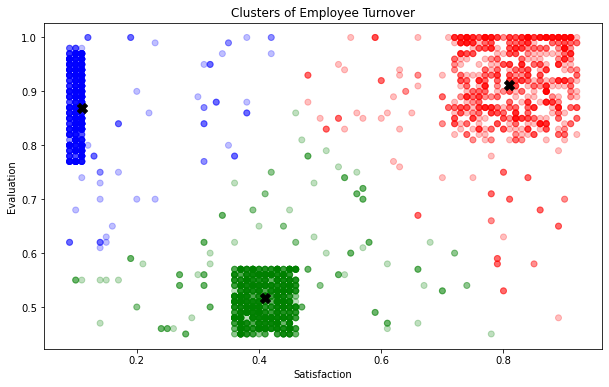

In [18]:
# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="satisfaction",y="evaluation", data=df[df.turnover==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Employee Turnover")
plt.show()

Does show distinct values for each cluster

<a id='eda4'></a>
# EDA 4. 
## Employee Satisfaction

There is a **tri-modal** distribution for employees that turnovered
- Employees who had really low satisfaction levels **(0.2 or less)** left the company more
- Employees who had low satisfaction levels **(0.3~0.5)** left the company more
- Employees who had really high satisfaction levels **(0.7 or more)** left the company more
-- Maybe becasue they got a better job, or promotion

Text(0.5, 1.0, 'Employee Satisfaction Distribution - Turnover VS No Turnover')

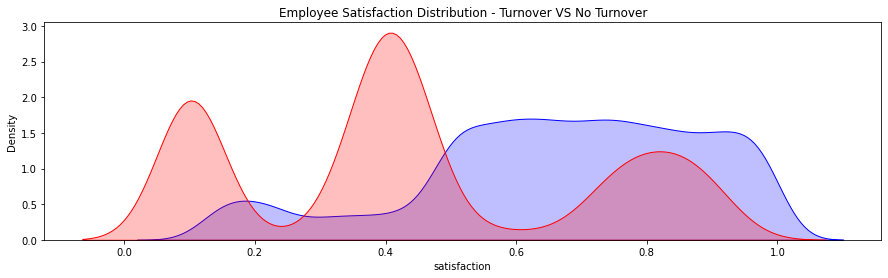

In [19]:
# KDEplot: Kernal Density Estimate plot

fig = plt.figure(figsize=(15,4))
ax = sns.kdeplot(df.loc[(df['turnover'] == 0), 'satisfaction'] , color ='b', shade=True, label='no turnover')
ax = sns.kdeplot(df.loc[(df['turnover'] == 1), 'satisfaction'] , color ='r', shade=True, label='turnover')
plt.title('Employee Satisfaction Distribution - Turnover VS No Turnover')

<a id='eda5'></a>
# EDA 5. 
## Employee Project Count 

Summary: 
- More than half of the employees with **2,6, and 7** projects left the company
- Majority of the employees who did not leave the company had **3,4, and 5** projects
- All of the employees with **7** projects left the company
- There is an increase in employee turnover rate as project count increases

[Text(0, 0.5, 'Percent')]

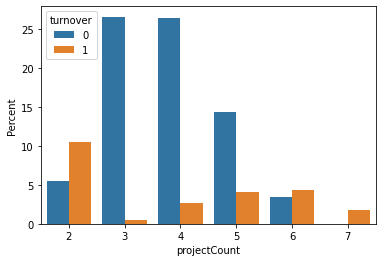

In [20]:
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

<a id='eda6'></a>
# EDA 6. 
## Employee Department Distribution

In [21]:
# Broke the data down to two groups left or not

hrleft = df[df['turnover']==1]

hrleft = pd.DataFrame(hrleft.department.value_counts()).reset_index()
hrstay = pd.DataFrame(df.department.value_counts()).reset_index()

hr_merge = pd.merge(hrleft,hrstay,how='inner', on='index')
hr_merge

,index,department_x,department_y
0,sales,1014,4140
1,technical,697,2720
2,support,555,2229
3,IT,273,1227
4,hr,215,739
5,accounting,204,767
6,marketing,203,858
7,product_mng,198,902
8,RandD,121,787
9,management,91,630


In [22]:
hr_merge = hr_merge.rename(columns={'department_x': 'left', 'department_y': 'stay','index': 'department'})
hr_merge

,department,left,stay
0,sales,1014,4140
1,technical,697,2720
2,support,555,2229
3,IT,273,1227
4,hr,215,739
5,accounting,204,767
6,marketing,203,858
7,product_mng,198,902
8,RandD,121,787
9,management,91,630


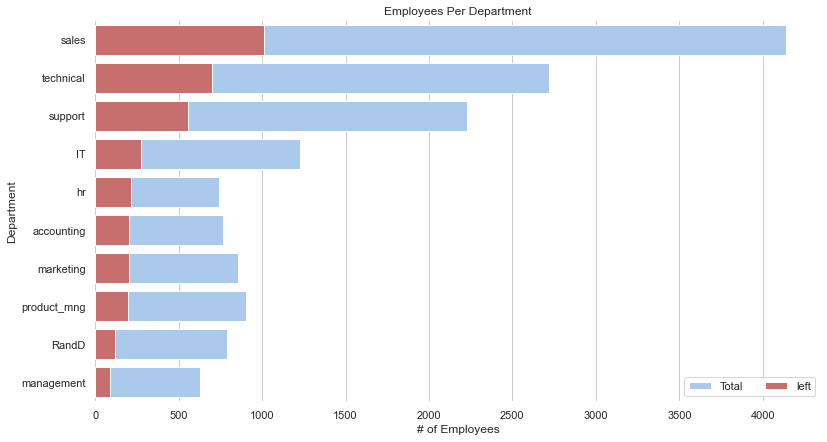

In [23]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure 
f, ax = plt.subplots(figsize=(13,7))

#plot the total schools per city
sns.set_color_codes('pastel')
sns.barplot(x='stay',y='department',data=hr_merge,label='Total',color='b')

#plot the total community schools per city
sns.set_color_codes('muted')
sns.barplot(x='left',y='department',data=hr_merge,label='left',color='r')

# Add a legend and information axis label
ax.legend(ncol=2,loc='lower right',frameon=True)
ax.set(ylabel='Department',title='Employees Per Department',xlabel='# of Employees')
sns.despine(left=True,bottom=True)

Can see that the sales, technical and support teams have the highest turnover rate

<a id='eda7'></a>
# EDA 7. 
## Average Monthly Hours

**Summary:** 
 - A bi-modal distribution for employees that turnovered 
 - Employees who had less hours of work **(~150hours or less)** left the company more
 - Employees who had too many hours of work **(~250 or more)** left the company 
 - Employees that worked between 180-210 hours have the least amount of turnover. 
 - Employees who left generally were **underworked** or **overworked**.



Text(0.5, 1.0, 'Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

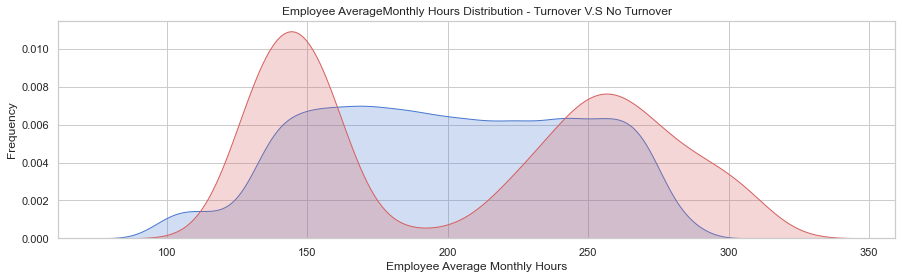

In [24]:
# KDEplot

fig = plt.figure(figsize=(15,4))
ax = sns.kdeplot(df.loc[(df['turnover'] == 0),'averageMonthlyHours'], color = 'b',shade=True,label = 'no turnover')
ax = sns.kdeplot(df.loc[(df['turnover'] == 1),'averageMonthlyHours'], color = 'r',shade=True,label = 'turnover')
ax.set(xlabel = 'Employee Average Monthly Hours', ylabel = 'Frequency')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

<a id='pre_processing'></a>
# Pre-processing 
***

- Apply **get_dummies()** to the non-ordered categorical variables 
- Seperate categorical variables and numeric variables, then combine them.

In [25]:
cat_var = ['department','salary','turnover','promotion']
num_var = ['satisfaction','evaluation','projectCount','averageMonthlyHours','yearsAtCompany','WorkAccident']

categorical_df = pd.get_dummies(df[cat_var],drop_first=True)
numerical_df = df[num_var]

new_df = pd.concat([categorical_df,numerical_df],axis=1)
new_df.head()

,turnover,promotion,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.38,0.53,2,157,3,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0.80,0.86,5,262,6,0
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0.11,0.88,7,272,4,0
3,1,0,0,0,0,0,0,0,1,0,0,1,0,0.72,0.87,5,223,5,0
4,1,0,0,0,0,0,0,0,1,0,0,1,0,0.37,0.52,2,159,3,0


<a id='class_imbalance'></a>
# Class Imbalance

### Employee Turnover Rate: 24%

In [26]:
df.turnover.value_counts(1)

0    0.761917
1    0.238083
Name: turnover, dtype: float64

Text(0, 0.5, 'Count')

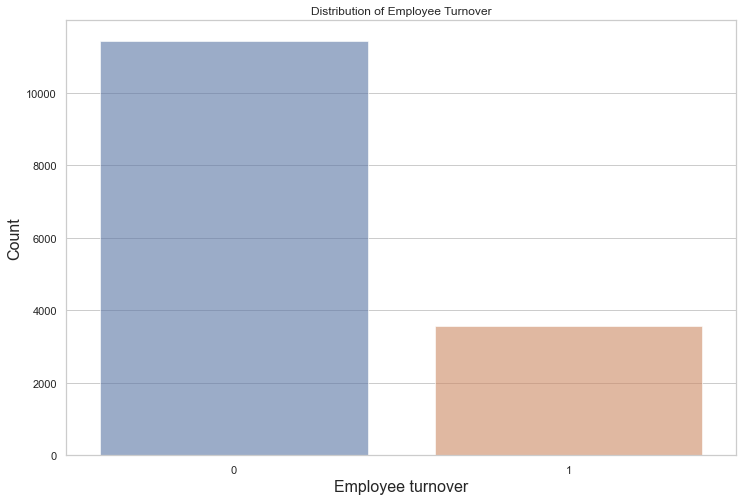

In [27]:
plt.figure(figsize=(12,8))
turnover = df.turnover.value_counts()
sns.barplot(y=turnover.values,x = turnover.index,alpha=0.6)
plt.title('Distribution of Employee Turnover')
plt.xlabel('Employee turnover', fontsize = 16)
plt.ylabel('Count',fontsize=16)

<a id='train-test'></a>
# Train Test Split

In [28]:
# Create the X and y set
# Create the X and y set
X = new_df.iloc[:,1:]
y = new_df.iloc[:,0]

# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

# How to Treat Imbalanced Datasets

There are many ways of dealing with imbalanced data. We will focus in the following approaches:

1. Oversampling — SMOTE
2. Undersampling — RandomUnderSampler

<a id='resample'></a>
# Resample Methods

Let's train a base logistic regression model on the three types of samples to see which yields the best result:
1. **Orginal Sample**
2. **Upsampling Data**
3. **Downsampling Data**

In [29]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", X_train_sm.shape, y_train_sm.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 18) (11999,)
Upsampled shape: (18284, 18) (18284,)
SMOTE sample shape: (18284, 18) (18284,)
Downsampled shape: (5714, 18) (5714,)


<a id='upsampling'></a>
# Choose Which Sampling Technique to Use For Model - Upsampling

### Apply 5-Fold Cross Validation for Logistic Regression
#### Train on Original, Upsampled, SMOTE, and Downsampled Data


## **Objective**:
Train our Logistic Regression Model to our **original, upsampled, and downsampled data** to see which performs best.

## Upsample
Randomly resample the minority class to create new data. 

## SMOTE
Use the nearest neighbors of the minority observations to create new synthetic data

## Downsample
Remove some samples of the majority class

In [30]:
# create the original, uPsampled, and Downsampled training sets 
methods_data = {'Original': (X_train,y_train),
               'Upsampled':(X_train_u,y_train_u),
               'SMOTE':(X_train_sm,y_train_sm),
               'Downsampled':(X_train_d,y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(max_iter=600), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced',max_iter=600), X_train, y_train, cv=5, scoring='f1').mean()

The best F1 Score for Original data:
0.4543242515135798
The best F1 Score for Upsampled data:
0.778546623385557
The best F1 Score for SMOTE data:
0.7915951010504433
The best F1 Score for Downsampled data:
0.7786407102431336


0.6094352090323296

 **Result:**
- **Original Sample**: F1 Score 45.4%
- **Upsample:** F1 Score 77.9%
- **SMOTE:** F1 Score 79.2%
- **Downsample:** F1 Score 77.9%

**SMOTE gives us the best performance**

# Train Three Models
***

1. Logistic Regression - Great for binary classification problems and easy to interpret the relationship between the the dependent and independent variables.
2. Random Forest - Decided to use because it uses random sampling of training data points when buidling trees, reduces overfitting in decision trees and helps to improve the accuracy
3. Gradient Boosting Classifier - Provides great predictive accuracy with lots of flexibility 

<a id='lr'></a>
# Test Logistic Regression Performance

- Testing smote training data using logistic regression
- Using logistic regression due to being a binary classification problem and to understand the relationshiip between the turnover and independent variables. 

In [31]:
lr = LogisticRegression(max_iter=600)

# Fit the model to the Upsampling data
lr = lr.fit(X_train_sm,y_train_sm)

print('\n\n ---Logistic Regression Model --- ')
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print('Logistic Regression AUC = %2.2f' % lr_auc)

lr2 = lr.fit(X_train_sm,y_train_sm)
print(classification_report(y_test,lr.predict(X_test)))



 ---Logistic Regression Model --- 
Logistic Regression AUC = 0.76
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2286
           1       0.50      0.77      0.60       714

    accuracy                           0.76      3000
   macro avg       0.70      0.76      0.71      3000
weighted avg       0.81      0.76      0.77      3000



<a id='rf'></a>
# Random Forest Classifier 
***

### Test on training data

In [32]:
# Random forest Model

rf = RandomForestClassifier()

rf_result = cross_val_score(rf,X_train_sm,y_train_sm,cv = 5, scoring='f1')

rf_result.mean()

0.9811082260874592

<a id='Gb'></a>
# Gradient Boosting Classifier
- Ensemble Method
- Works on Weak classifiers 

### Test on training data

In [34]:
gbc = GradientBoostingClassifier()

gbc = gbc.fit(X_train_sm,y_train_sm)

gbc

GradientBoostingClassifier()

In [35]:
gbc_result = cross_val_score(gbc,X_train_sm,y_train_sm,cv=5, scoring = 'f1')
gbc_result.mean()

0.9580470716647115

<a id='roc'></a>
# ROC Graph
- Tells the ratio between the true positive rate vs false positive rate 
- More top left the better.
- Is a more robust metric to use than accuracy

In [52]:
rf.predict_proba(X_test)

array([[1.  , 0.  ],
       [0.26, 0.74],
       [0.87, 0.13],
       ...,
       [0.96, 0.04],
       [0.96, 0.04],
       [0.  , 1.  ]])

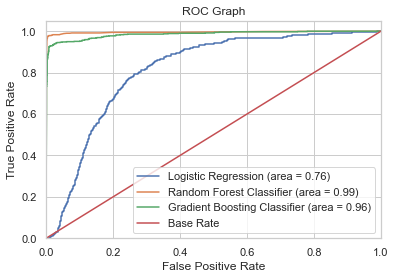

In [53]:
# Create ROC Graph

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Results 
- Looks like the roc graph is showing good resutls for the models
- Random forest performs the best with a 98% chance to distinguish between the positve class (Did not leave) and negative class (Did leave)

<a id='Testing'></a>
# LET'S MAKE PREDICTIONS ON THE TEST DATA 
- Using the logistic regression, gradient boosting and random forest algorithms.

# Logistic Regression

In [54]:
# Confusion Matrix 

confusion_matrix(y_test,lr.predict(X_test))

array([[1729,  557],
       [ 167,  547]])

In [61]:
y_pred = lr.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for lr: %.2f%%" % (accuracy * 100.0))

Accuracy for lr: 75.87%


### Gradient Boosting Classifier

In [66]:
print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.91      0.94      0.92       714

    accuracy                           0.96      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.96      0.96      0.96      3000



In [55]:
confusion_matrix(y_test,gbc.predict(X_test))

array([[2220,   66],
       [  43,  671]])

In [58]:
y_pred = gbc.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for gbc: %.2f%%" % (accuracy * 100.0))

Accuracy for gbc: 96.37%


### Random Forest

In [68]:
rf = rf.fit(X_train_sm,y_train_sm)

print('\n\n ---Random Forest Model---')
rf_roc_auc = roc_auc_score(y_test,rf.predict(X_test))
print('Random Forest AUC = %2.2f' % rf_roc_auc)
print(classification_report(y_test,rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [56]:
confusion_matrix(y_test,rf.predict(X_test))

array([[2267,   19],
       [  15,  699]])

In [59]:
y_pred = rf.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for rf: %.2f%%" % (accuracy * 100.0))

Accuracy for rf: 98.87%


### Results 
- Random forest is still performing the best at 98.9% and when it comes minimizing the false negatives/recall which is where the model predicts the employee will not leave the company but does and we want to capture as many employees as we can that have a high risk of leaving and to do that, we have to limit the false negatives. 
- Random forest shows 2,962 correct predictions and 38 incorrect predictions. 
- Logistic regression is performing the least at 76%
- Interpretation - with random forest about 99% of the employees will be predicted not leave. 

<a id='feature_importance'></a>
# Random Forest Feature Importances

In [62]:
# Get feature importance 
feature_importances = pd.DataFrame(rf.feature_importances_,
                                  index = X_train.columns,
                                  columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,satisfaction,0.277705
1,yearsAtCompany,0.232613
2,averageMonthlyHours,0.152785
3,projectCount,0.140650
4,evaluation,0.134935
5,WorkAccident,0.024363
6,salary_low,0.007150
7,salary_medium,0.004560
8,department_sales,0.004520
9,department_technical,0.004094


<AxesSubplot:xlabel='importance', ylabel='index'>

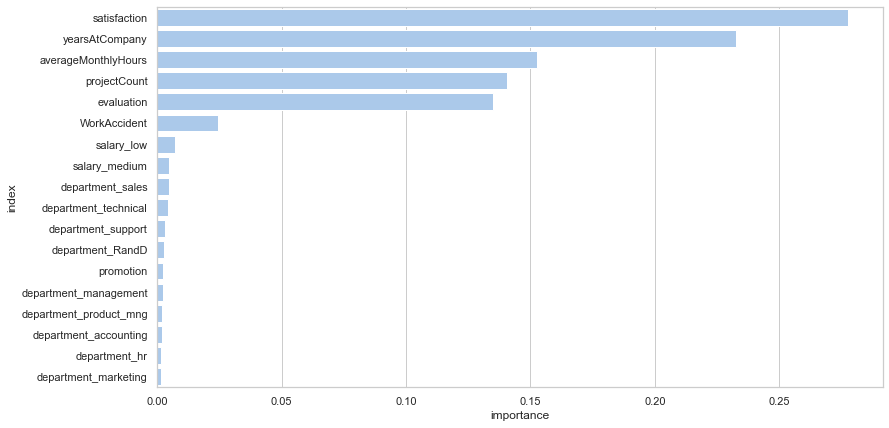

In [63]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

Top five most impactful features that have a great relationship with our target are (Satisfaction, yearsatCompany, averageMonthlyHours, ProjectCount, evaluation)

## Apply Random Noise to Feature Importance
- Experimenting to see which part of these features acutally play some significance in our turnover label. 
- Random noise will spit out random numbers from 0-1

<AxesSubplot:xlabel='importance', ylabel='index'>

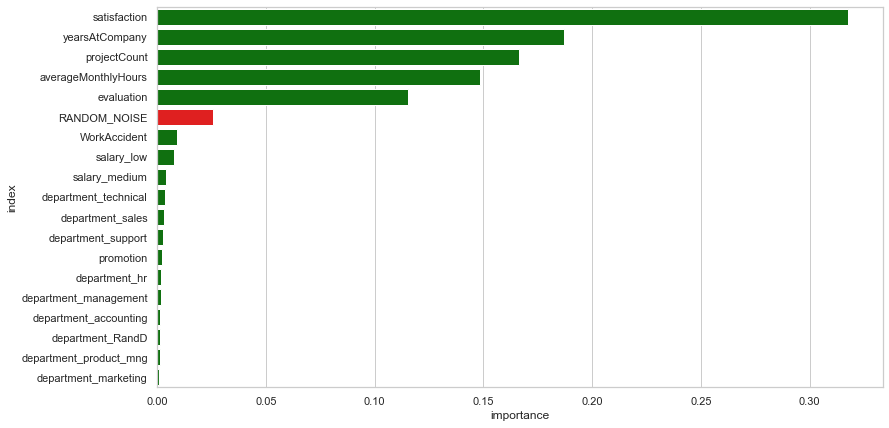

In [64]:
# Apply Random Noise to data set. Create new featue called random noise 
X_train_rnoise = pd.DataFrame(X_train)
X_train_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet
rf_random = RandomForestClassifier()
rf_random = rf_random.fit(X_train_rnoise, y_train)

# Get Feature Importances
feature_importances_random = pd.DataFrame(rf_random.feature_importances_, index = X_train_rnoise.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))


clrs = ['red' if (x == 5 ) else 'green' for x in feature_importances_random.index.values ]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random,
            label="Total",  palette=clrs)

In [65]:
X_train_rnoise.head()

,promotion,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,WorkAccident,RANDOM_NOISE
6197,0,0,0,0,0,0,0,1,0,0,1,0,0.15,0.39,5,229,4,0,-0.021342
1955,0,0,0,0,0,0,0,0,1,0,1,0,0.09,0.81,6,257,4,0,0.336176
9440,0,0,0,0,0,0,0,0,1,0,1,0,0.57,0.49,2,237,2,0,0.952823
9365,0,0,0,0,0,0,0,0,1,0,1,0,0.85,0.59,2,264,2,0,1.177223
7725,0,0,0,0,0,0,0,1,0,0,0,0,0.16,0.72,4,192,6,0,1.809150


### Results 
- Ranodom noise(red bar) only have about 3% importance while the top 5 features are still at the top
- Can maybe just use the top 5 features for modeling since any features below the random noise does not have much of an impact. 

***

<a id='report'></a>
# The Report

| Algorithm             | Accuracy |
|--------------------   |----------|
| Randome Forest        | 99.8%    |
| Gradient Boosting     | 96.4%    |
| Logistic Regression   | 75.9%    |

***

<a id='Conclusion'></a>
# The Conclusion

- Top five most impactful features that have a great relationship with our target are (Satisfaction, yearsatCompany, averageMonthlyHours, ProjectCount, evaluation)
- Random forest performs the best at 98.9% accuracy and minimizes the false negatives because we want to capture as many employees as we can that have a high risk of leaving. 
- Our Random forest models shows only about 38 incorrect predictions.


## What to Optimize:
- We want our machine learning model to capture as much of the minority class as possible (turnover group). Our objective is to catch ALL of the highly probable turnover employee at the risk of flagging some low-risk non-turnover employee.


## Selection Bias:
- One thing to note about this dataset is the turnover feature. We don't know if the employees that left are interns, contractors, full-time, or part-time. These are important variables to take into consideration when performing a machine learning algorithm to it.
- Another thing to note down is the type of bias of the evaluation feature. Evaluation is heavily subjective, and can vary tremendously depending on who is the evaluator. If the employee knows the evaluator, then he/she will probably have a higher score.

### Next time:

- I would try to run Support Vector Machine because it is great for binary classification problems and produces significant accuracy with less computation power.